In [1]:
import sys
sys.path.append("..")
from sklearn.datasets import load_wine
from deep_svdd import BaseSVDD
import os
import sys
import csv
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import keras
import glob
import cv2
from keras import layers
from sklearn.model_selection import train_test_split
from keras.layers import Lambda, Input, Dense
from keras.models import Model
from keras.losses import mse
from keras import backend as K
from keras import models
param = 2**(-4)

In [2]:
X_list = glob.glob('bottle/train/good/*.png')
Y_list1 = glob.glob('bottle/test/broken_large/*.png')
Y_list2 = glob.glob('bottle/test/broken_small/*.png')
Y_list3 = glob.glob('bottle/test/contamination/*.png')
Y_list4 = glob.glob('bottle/test/good/*.png')
X_train = None
X_test_good = None
X_test_error = None
for X_file in X_list:
  im = cv2.imread(X_file)
  im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
  im = cv2.resize(im, (256,256))
  im = im.reshape(1,im.shape[0],im.shape[1],im.shape[2])
  if X_train is not None:
    X_train = np.concatenate((X_train, im))
  if X_train is None:
    X_train = im

for Y_file in Y_list1:
  im = cv2.imread(Y_file)
  im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
  im = cv2.resize(im, (256,256))
  im = im.reshape(1,im.shape[0],im.shape[1],im.shape[2])
  if X_test_error is not None:
    X_test_error = np.concatenate((X_test_error, im))
  if X_test_error is None:
    X_test_error = im

for Y_file in Y_list2:
  im = cv2.imread(Y_file)
  im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
  im = cv2.resize(im, (256,256))
  im = im.reshape(1,im.shape[0],im.shape[1],im.shape[2])
  if X_test_error is not None:
    X_test_error = np.concatenate((X_test_error, im))
  if X_test_error is None:
    X_test_error = im

for Y_file in Y_list3:
  im = cv2.imread(Y_file)
  im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
  im = cv2.resize(im, (256,256))
  im = im.reshape(1,im.shape[0],im.shape[1],im.shape[2])
  if X_test_error is not None:
    X_test_error = np.concatenate((X_test_error, im))
  if X_test_error is None:
    X_test_error = im

for Y_file in Y_list4:
  im = cv2.imread(Y_file)
  im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
  im = cv2.resize(im, (256,256))
  im = im.reshape(1,im.shape[0],im.shape[1],im.shape[2])
  if X_test_good is not None:
    X_test_good = np.concatenate((X_test_good, im))
  if X_test_good is None:
    X_test_good = im

X_train = X_train/255
X_test_good = X_test_good/255
X_test_error = X_test_error/255
x_train, x_test = train_test_split(X_train, test_size=0.2)

In [3]:
class Sampling(layers.Layer):
    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon
latent_dim = 20

class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(name="reconstruction_loss")
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]

    def predict(self, x):
        z_mean, _, _ = self.encoder.predict(x)
        y = self.decoder.predict(z_mean)
        return y

    def train_step(self, data):
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)
            reconstruction = self.decoder(z)
            reconstruction_loss = tf.reduce_mean(
                tf.reduce_sum(
                    keras.losses.binary_crossentropy(data, reconstruction), axis=(1, 2)
                )
            )
            kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))
            total_loss = reconstruction_loss + kl_loss
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }

In [4]:
encoder_inputs = keras.Input(shape=(256, 256, 3))

x = layers.Conv2D(64, 3, activation="relu", padding="same")(encoder_inputs)
x = layers.MaxPooling2D(pool_size=(2, 2), padding='same')(x)

x = layers.Conv2D(16, 3, activation="relu", padding="same")(x)
x = layers.MaxPooling2D(pool_size=(2, 2), padding='same')(x)

x = layers.Conv2D(8, 3, activation="relu", padding="same")(x)
x = layers.MaxPooling2D(pool_size=(2, 2), padding='same')(x)

x = layers.Flatten()(x)
z_mean = layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
z = Sampling()([z_mean, z_log_var])
encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")
encoder.summary()

latent_inputs = keras.Input(shape=(latent_dim,))
x = layers.Dense(32*32*8, activation="relu")(latent_inputs)
x = layers.Reshape((32, 32, 8))(x)
x = layers.Conv2D(8, 3, activation="relu", padding="same")(x)
x = layers.UpSampling2D(size=(2, 2))(x)
x = layers.Conv2D(16, 3, activation="relu", padding="same")(x)
x = layers.UpSampling2D(size=(2, 2))(x)
x = layers.Conv2D(64, 3, activation="relu", padding="same")(x)
x = layers.UpSampling2D(size=(2, 2))(x)
decoder_outputs = layers.Conv2D(3, 3, activation="relu", padding="same")(x)
decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")
decoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 256, 256, 64  1792        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 max_pooling2d (MaxPooling2D)   (None, 128, 128, 64  0           ['conv2d[0][0]']                 
                                )                                                           

In [5]:
%%time
vae = VAE(encoder, decoder)
vae.compile(optimizer=keras.optimizers.Adam())
history = vae.fit(x_train, epochs=30, batch_size=64)

Epoch 1/30
3/3 [==============================] - 93s 25s/step - loss: 350101.0781 - reconstruction_loss: 314300.9062 - kl_loss: 37.2229
Epoch 2/30
3/3 [==============================] - 89s 26s/step - loss: 170996.1133 - reconstruction_loss: 151867.7656 - kl_loss: 4159.5552
Epoch 3/30
3/3 [==============================] - 84s 25s/step - loss: 63606.3271 - reconstruction_loss: 63181.0312 - kl_loss: 330.4551
Epoch 4/30
3/3 [==============================] - 77s 24s/step - loss: 56788.3057 - reconstruction_loss: 54920.6406 - kl_loss: 222.9807
Epoch 5/30
3/3 [==============================] - 83s 25s/step - loss: 44212.9707 - reconstruction_loss: 42644.5117 - kl_loss: 279.9061
Epoch 6/30
3/3 [==============================] - 79s 21s/step - loss: 38172.1504 - reconstruction_loss: 37306.1992 - kl_loss: 340.6920
Epoch 7/30
3/3 [==============================] - 49s 12s/step - loss: 33093.4141 - reconstruction_loss: 32215.3887 - kl_loss: 286.0209
Epoch 8/30
3/3 [============================

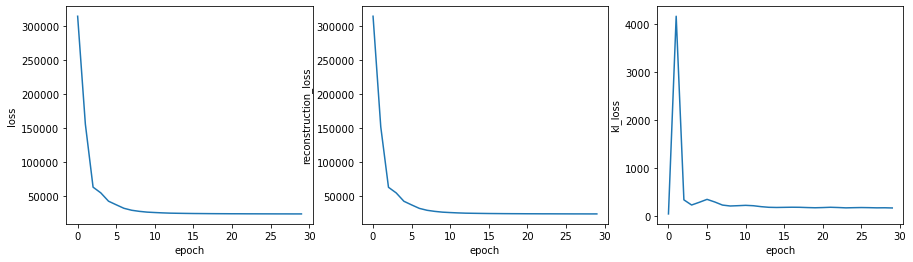

In [7]:
row = 1
col = 3
fig, ax = plt.subplots(row, col, figsize=(15,4))
ax[0].plot(history.history["loss"])
ax[0].set_ylabel('loss')
ax[0].set_xlabel('epoch')
ax[1].plot(history.history["reconstruction_loss"])
ax[1].set_ylabel('reconstruction_loss')
ax[1].set_xlabel('epoch')
ax[2].plot(history.history["kl_loss"])
ax[2].set_ylabel('kl_loss')
ax[2].set_xlabel('epoch')
plt.show()

In [8]:
# _, _, x_tr = encoder.predict(X_train)
# _, _, x_tg = encoder.predict(X_test_good)
# _, _, x_te = encoder.predict(X_test_error)
x_tr, _, _ = encoder.predict(X_train)
x_tg, _, _ = encoder.predict(X_test_good)
x_te, _, _ = encoder.predict(X_test_error)

2/2 [==============================] - 1s 427ms/step


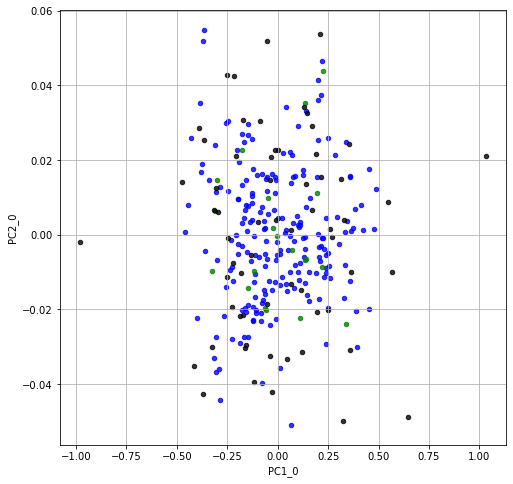

In [12]:
from sklearn.decomposition import PCA
pca = PCA()
pca.fit(x_tr)
f_train = pca.transform(x_tr)

pca.fit(x_tg)
f_test_0 = pca.transform(x_tg)

pca.fit(x_te)
f_test_1 = pca.transform(x_te)

plt.figure(figsize=(8, 8))

plt.scatter(f_train[:, 0], f_train[:, 1], alpha=0.8, c='b', s = 20)
plt.scatter(f_test_0[:, 0], f_test_0[:, 1], alpha=0.8, c='g', s = 20)
plt.scatter(f_test_1[:, 0], f_test_1[:, 1], alpha=0.8, c='black', s = 20)

plt.grid()
plt.xlabel("PC1_0")
plt.ylabel("PC2_0")
plt.show()



*** Fitting of the SVDD model is completed. ***

running time         = 0.1744 seconds
kernel function      = rbf
iterations           = 11
number of samples    = 209
number of features   = 20
number of SVs        = 18
ratio of SVs         = 8.6124 %
accuracy             = 96.6507 %




*** Prediction of the provided data is completed. ***

running time         = 0.0000 seconds
number of samples    = 209
number of alarm      = 7




*** Prediction of the provided data is completed. ***

running time         = 0.0000 seconds
number of samples    = 20
number of alarm      = 4




*** Prediction of the provided data is completed. ***

running time         = 0.0000 seconds
number of samples    = 63
number of alarm      = 14




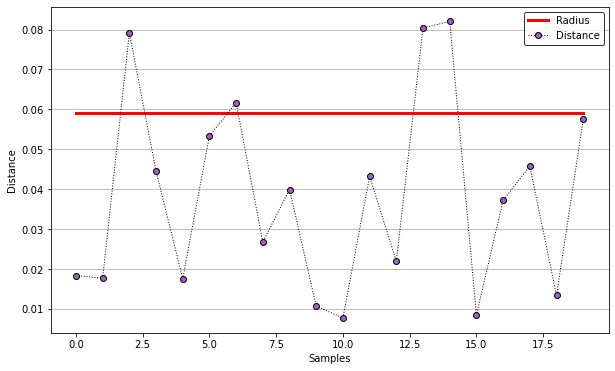

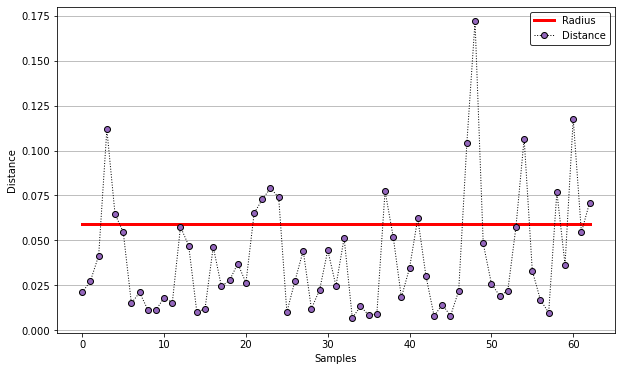

CPU times: total: 1.59 s
Wall time: 842 ms


In [9]:
%%time
svdd = BaseSVDD(C=param, gamma=0.01, kernel='rbf', display='on')

svdd.fit(x_tr)
pre_t = svdd.predict(x_tr)
pre_g = svdd.predict(x_tg)
pre_e = svdd.predict(x_te)
radius = svdd.radius
distance = svdd.get_distance(x_tg)
svdd.plot_distance(radius, distance)
distance = svdd.get_distance(x_te)
svdd.plot_distance(radius, distance)

alphas = svdd.alpha
Param = svdd.C

In [10]:
m, n = x_tr.shape
SV = []
NSV = []
for i in range(m):
  if alphas[i] > 0 and alphas[i] <= Param[0]:
    SV.append(list(X_train[i, :, :, :]))
#   elif alphas[i] == Param:
#     SV.append(list(X_train[i, :, :, :]))
  else:
    NSV.append(list(X_train[i, :, :, :]))

sv = np.array(SV)
nsv = np.array(NSV)

Epoch 1/30
1/1 [==============================] - 4s 4s/step - loss: 24314.9199 - reconstruction_loss: 24154.4238 - kl_loss: 160.4969
Epoch 2/30
1/1 [==============================] - 4s 4s/step - loss: 24307.3945 - reconstruction_loss: 24146.4648 - kl_loss: 160.9294
Epoch 3/30
1/1 [==============================] - 4s 4s/step - loss: 24297.6660 - reconstruction_loss: 24137.6250 - kl_loss: 160.0402
Epoch 4/30
1/1 [==============================] - 4s 4s/step - loss: 24291.8867 - reconstruction_loss: 24133.0391 - kl_loss: 158.8483
Epoch 5/30
1/1 [==============================] - 4s 4s/step - loss: 24279.7012 - reconstruction_loss: 24121.2070 - kl_loss: 158.4945
Epoch 6/30
1/1 [==============================] - 4s 4s/step - loss: 24274.8770 - reconstruction_loss: 24116.2188 - kl_loss: 158.6591
Epoch 7/30
1/1 [==============================] - 4s 4s/step - loss: 24265.4238 - reconstruction_loss: 24106.6113 - kl_loss: 158.8130
Epoch 8/30
1/1 [==============================] - 4s 4s/step -

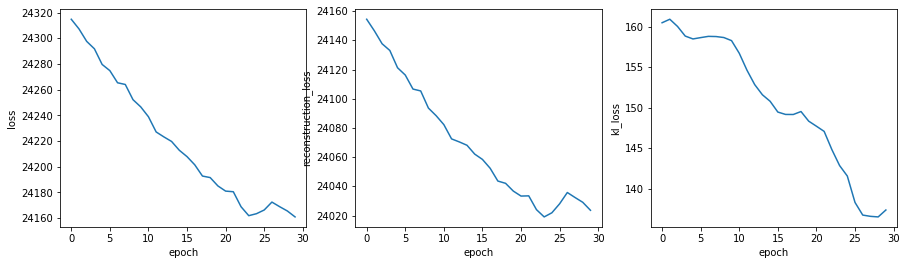

In [11]:
history = vae.fit(sv, epochs=30, batch_size=64)
row = 1
col = 3
fig, ax = plt.subplots(row, col, figsize=(15,4))
ax[0].plot(history.history["loss"])
ax[0].set_ylabel('loss')
ax[0].set_xlabel('epoch')
ax[1].plot(history.history["reconstruction_loss"])
ax[1].set_ylabel('reconstruction_loss')
ax[1].set_xlabel('epoch')
ax[2].plot(history.history["kl_loss"])
ax[2].set_ylabel('kl_loss')
ax[2].set_xlabel('epoch')
plt.show()

In [15]:
x_tr, _, _ = encoder.predict(X_train)
x_tg, _, _ = encoder.predict(X_test_good)
x_te, _, _ = encoder.predict(X_test_error)

2/2 [==============================] - 1s 516ms/step




*** Fitting of the SVDD model is completed. ***

running time         = 0.0825 seconds
kernel function      = rbf
iterations           = 11
number of samples    = 209
number of features   = 20
number of SVs        = 18
ratio of SVs         = 8.6124 %
accuracy             = 96.6507 %




*** Prediction of the provided data is completed. ***

running time         = 0.0000 seconds
number of samples    = 209
number of alarm      = 7




*** Prediction of the provided data is completed. ***

running time         = 0.0158 seconds
number of samples    = 20
number of alarm      = 4




*** Prediction of the provided data is completed. ***

running time         = 0.0000 seconds
number of samples    = 63
number of alarm      = 14




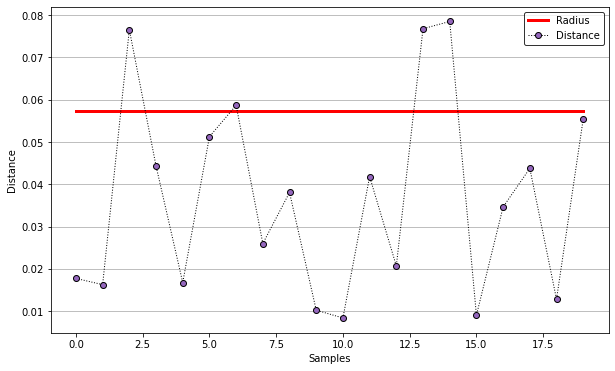

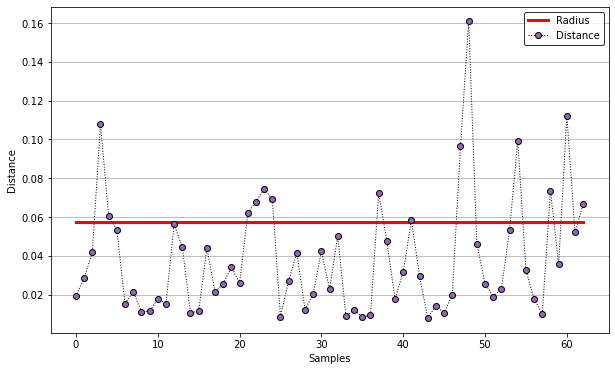

CPU times: total: 1.56 s
Wall time: 774 ms


In [16]:
%%time
svdd = BaseSVDD(C=param, gamma=0.01, kernel='rbf', display='on')

svdd.fit(x_tr)
pre_t = svdd.predict(x_tr)
pre_g = svdd.predict(x_tg)
pre_e = svdd.predict(x_te)
radius = svdd.radius
distance = svdd.get_distance(x_tg)
svdd.plot_distance(radius, distance)
distance = svdd.get_distance(x_te)
svdd.plot_distance(radius, distance)

alphas = svdd.alpha
Param = svdd.C